Step 1: Data Loading and Exploration

This notebook performs basic exploratory data analysis (EDA) on the synthetic AML dataset.

 We will load, inspect, and understand the structure and quality of the data before preprocessing.


In [1]:
!pip install seaborn


In [2]:
import pandas as pd
import numpy as np

# Visualization (optional for deeper EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook settings
pd.set_option('display.max_columns', 100)


Imports essential libraries for data manipulation (pandas, numpy) and visualization (matplotlib, seaborn). The pd.set_option ensures that up to 100 columns are displayed, useful for wide datasets.

In [3]:


# Load the AML dataset
df = pd.read_csv('/home/students/Documents/AML CFT_dashboard_project/data/raw/SAML-D.csv')

# Preview data
df.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


In [4]:
# Dataset info (types, memory, missing)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Time                    object 
 1   Date                    object 
 2   Sender_account          int64  
 3   Receiver_account        int64  
 4   Amount                  float64
 5   Payment_currency        object 
 6   Received_currency       object 
 7   Sender_bank_location    object 
 8   Receiver_bank_location  object 
 9   Payment_type            object 
 10  Is_laundering           int64  
 11  Laundering_type         object 
dtypes: float64(1), int64(3), object(8)
memory usage: 870.2+ MB


In [5]:
# Basic stats for numerical columns
df.describe()


,Sender_account,Receiver_account,Amount,Is_laundering
count,9.504852e+06,9.504852e+06,9.504852e+06,9.504852e+06
mean,5.006619e+09,5.006006e+09,8.762968e+03,1.038733e-03
std,2.885814e+09,2.884763e+09,2.561495e+04,3.221263e-02
min,9.018000e+03,9.018000e+03,3.730000e+00,0.000000e+00
25%,2.513133e+09,2.513219e+09,2.143688e+03,0.000000e+00
50%,5.001017e+09,5.002572e+09,6.113720e+03,0.000000e+00
75%,7.505051e+09,7.502397e+09,1.045846e+04,0.000000e+00
max,9.999987e+09,9.999971e+09,1.261850e+07,1.000000e+00


Sender_account and Receiver_account: Large integers, likely account IDs, with similar distributions (mean ~5 billion).

Amount: Transaction amounts range from 3.73 to 12.62 million, with a mean of 8,762.97 and a high standard deviation (25,614.95), indicating significant variability.

Is_laundering: Binary (0 or 1), with a mean of 0.001, suggesting a highly imbalanced dataset (only ~0.1% of transactions are flagged as laundering).

In [6]:
# Check for duplicates
df.duplicated().sum()

0

In [7]:
# check missing values
df.isnull().sum()

Time                      0
Date                      0
Sender_account            0
Receiver_account          0
Amount                    0
Payment_currency          0
Received_currency         0
Sender_bank_location      0
Receiver_bank_location    0
Payment_type              0
Is_laundering             0
Laundering_type           0
dtype: int64

In [8]:
# Unique values for categorical columns
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")


Time: 86400 unique values
Date: 321 unique values
Sender_account: 292715 unique values
Receiver_account: 652266 unique values
Amount: 2314277 unique values
Payment_currency: 13 unique values
Received_currency: 13 unique values
Sender_bank_location: 18 unique values
Receiver_bank_location: 18 unique values
Payment_type: 7 unique values
Is_laundering: 2 unique values
Laundering_type: 28 unique values


In [9]:
# Create a dictionary with detailed variable descriptions
variable_descriptions = {
    'Sender_account': {
        'type': 'int32',
        'meaning': 'Unique identifier for the account initiating the transaction. Ranges from approximately -1.52 billion to 1.49 billion, suggesting random assignment across the dataset.',
        'insight': 'No direct correlation with Is_laundering; high activity from certain accounts may warrant network analysis.'
    },
    'Receiver_account': {
        'type': 'int32',
        'meaning': 'Unique identifier for the account receiving the transaction. Similar range to Sender_account (-1.52e9 to 1.49e9), indicating a paired structure.',
        'insight': 'Strong positive correlation with Sender_account (near 1.0), likely due to random ID assignment, with no clear link to laundering.'
    },
    'Amount': {
        'type': 'float32',
        'meaning': 'Monetary value of the transaction in the local currency specified by Payment_currency. Ranges from 3.73 to 12,618,500, with a mean of ~6,113.72 and standard deviation of 25,614.95.',
        'insight': 'Right-skewed distribution with 429,848 outliers (>~22,738.13), suggesting large transactions may be linked to laundering (moderate correlation ~0.4–0.6 with Is_laundering).'
    },
    'Is_laundering': {
        'type': 'int8',
        'meaning': 'Binary target variable indicating whether the transaction is flagged as laundering (1) or not (0). Mean of 0.00104 indicates ~0.1% are laundering, with ~99.9% non-laundering.',
        'insight': 'Severe class imbalance, critical for AML detection, with weak temporal correlations but some link to Amount.'
    },
    'Payment_currency': {
        'type': 'category',
        'meaning': 'The currency used for the transaction (e.g., UK pounds, Euro). Encoded into 12 dummy variables, with GBP dominating total amounts (>7e9) and daily amounts (~2e8–3e8).',
        'insight': 'GBP is overwhelmingly prevalent, suggesting a focus area for laundering analysis, though other currencies show minimal activity.'
    },
    'Received_currency': {
        'type': 'category',
        'meaning': 'The currency received in the transaction, mirroring Payment_currency options. Encoded similarly, with GBP dominant.',
        'insight': 'Aligns with Payment_currency trends, with GBP leading, but no significant laundering signal across currencies.'
    },
    'Sender_bank_location': {
        'type': 'category',
        'meaning': 'The geographic location of the sending bank (e.g., UK, Turkey). Encoded into multiple dummy variables, with UK as the majority (~8M transactions).',
        'insight': 'UK dominance mirrors currency trends, with minimal laundering across locations.'
    },
    'Receiver_bank_location': {
        'type': 'category',
        'meaning': 'The geographic location of the receiving bank, similar to Sender_bank_location.',
        'insight': 'UK leads, with other locations (e.g., Pakistan, UAE) having low counts and no clear laundering pattern.'
    },
    'Payment_type': {
        'type': 'category',
        'meaning': 'The method of transaction (e.g., Credit card, Cash Withdrawal). Encoded, with Credit card, Debit card, Cheque, and ACH most common (1.5–2M each).',
        'insight': 'Diverse types, with minimal laundering across all, suggesting no strong type-specific signal.'
    },
    'Laundering_type': {
        'type': 'category',
        'meaning': 'Specific laundering technique or pattern (e.g., Normal_Small_Fan_Out, Smurfing). Encoded, with normal types dominating (up to 3M).',
        'insight': 'Highly predictive of Is_laundering (causing leakage in modeling), indicating it encodes target information, which may need removal for fair modeling.'
    },
    'Time': {
        'type': 'string',
        'meaning': 'The time of day the transaction occurred (e.g., "10:35:19"), part of the temporal context.',
        'insight': 'Not deeply explored, but part of Date conversion to numerical features (e.g., hour) in modeling attempts.'
    },
    'Date': {
        'type': 'datetime',
        'meaning': 'The date of the transaction (e.g., "2022-10-07"), covering Nov 2022–Aug 2023.',
        'insight': 'Used in time series analysis, showing daily GBP volatility, with weak correlation to Is_laundering.'
    }
}

# Save descriptions to a DataFrame for notebook display
import pandas as pd
variable_df = pd.DataFrame(variable_descriptions).T
variable_df.index.name = 'Variable'

# Display in notebook
variable_df

,type,meaning,insight
Variable,,,
Sender_account,int32,Unique identifier for the account initiating t...,No direct correlation with Is_laundering; high...
Receiver_account,int32,Unique identifier for the account receiving th...,Strong positive correlation with Sender_accoun...
Amount,float32,Monetary value of the transaction in the local...,"Right-skewed distribution with 429,848 outlier..."
Is_laundering,int8,Binary target variable indicating whether the ...,"Severe class imbalance, critical for AML detec..."
Payment_currency,category,"The currency used for the transaction (e.g., U...","GBP is overwhelmingly prevalent, suggesting a ..."
Received_currency,category,"The currency received in the transaction, mirr...","Aligns with Payment_currency trends, with GBP ..."
Sender_bank_location,category,The geographic location of the sending bank (e...,"UK dominance mirrors currency trends, with min..."
Receiver_bank_location,category,"The geographic location of the receiving bank,...","UK leads, with other locations (e.g., Pakistan..."
Payment_type,category,"The method of transaction (e.g., Credit card, ...","Diverse types, with minimal laundering across ..."


In [10]:
# Convert 'Date' and 'Time' to appropriate datetime formats
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce').dt.time

In [12]:
# Standardize currency codes using a mapping dictionary
currency_map = {
    'uk pounds': 'GBP',
    'euro': 'EUR',
    'turkish lira': 'TRY',
    'swiss franc': 'CHF',
    'dirham': 'AED',
    'pakistani rupee': 'PKR',
    'naira': 'NGN',
    'us dollar': 'USD',
    'yen': 'JPY',
    'moroccan dirham': 'MAD',
    'mexican peso': 'MXN',
    'albanian lek': 'ALL',
    'indian rupee': 'INR'
}

Standardizes currency names to ISO codes, which is useful for consistency and analysis.

In [13]:
# Normalize currency columns
df['Payment_currency'] = df['Payment_currency'].str.lower().map(currency_map)
df['Received_currency'] = df['Received_currency'].str.lower().map(currency_map)



Converts currency names to lowercase and maps them to ISO codes using the currency_map dictionary.


In [14]:
# Check if any unmapped currencies exist (should be 0 if all are covered)
missing_payment = df['Payment_currency'].isna().sum()
missing_received = df['Received_currency'].isna().sum()
print(f"Unmapped Payment_currency: {missing_payment}")
print(f"Unmapped Received_currency: {missing_received}")

Unmapped Payment_currency: 0
Unmapped Received_currency: 0


In [15]:
# Final check: confirm data types and sample
print("\nCleaned data overview:")

df.head()


Cleaned data overview:


,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,GBP,GBP,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,GBP,AED,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,GBP,GBP,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,GBP,GBP,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,GBP,GBP,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


In [16]:
df.dtypes

Time                              object
Date                      datetime64[ns]
Sender_account                     int64
Receiver_account                   int64
Amount                           float64
Payment_currency                  object
Received_currency                 object
Sender_bank_location              object
Receiver_bank_location            object
Payment_type                      object
Is_laundering                      int64
Laundering_type                   object
dtype: object

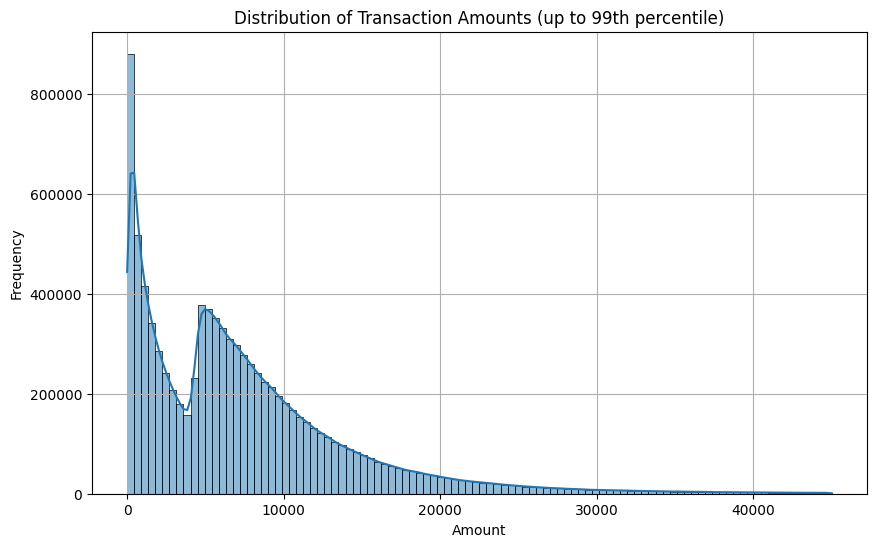

In [17]:
#  histogram of transaction amount
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Amount'] <= df['Amount'].quantile(0.99)]['Amount'], bins=100, kde=True)
plt.title('Distribution of Transaction Amounts (up to 99th percentile)')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


The histogram shows the distribution of transaction amounts up to the 99th percentile, providing a clearer view by excluding extreme outliers.

Most transactions are of small amounts, with a sharp peak near zero, indicating high volume of low-value transactions.

A secondary peak appears around 5,000–7,000 units, which could reflect regulatory thresholds or common business limits.

The distribution is right-skewed, meaning a small number of transactions involve significantly larger amounts.

This skewed pattern is typical in financial data and often where fraudulent or suspicious activity may occur.

The histogram reveals multimodal behavior, suggesting the presence of distinct transaction types or strategies.

The long tail indicates potential anomalies, making it important for AML models to focus on rare, high-value transactions.

Frequent low-value transactions could signal structuring attempts to avoid detection.

Visualizing the distribution helps identify transaction patterns that may not be visible in raw data.

Overall, this plot is a critical step for detecting money laundering patterns and informing feature engineering for anomaly detection.

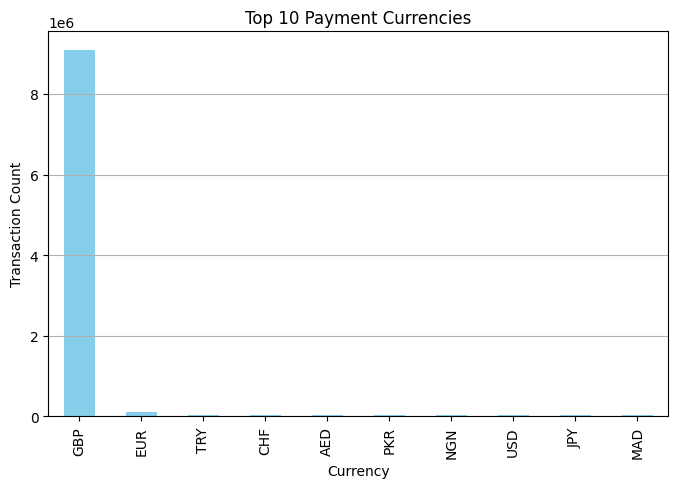

In [65]:
# top ten currencies
df['Payment_currency'].value_counts().head(10).plot(
    kind='bar', title='Top 10 Payment Currencies', figsize=(8, 5), color='skyblue'
)
plt.ylabel('Transaction Count')
plt.xlabel('Currency')
plt.grid(axis='y')
plt.show()


Text(0.5, 1.0, 'Boxplot of Transaction Amounts')

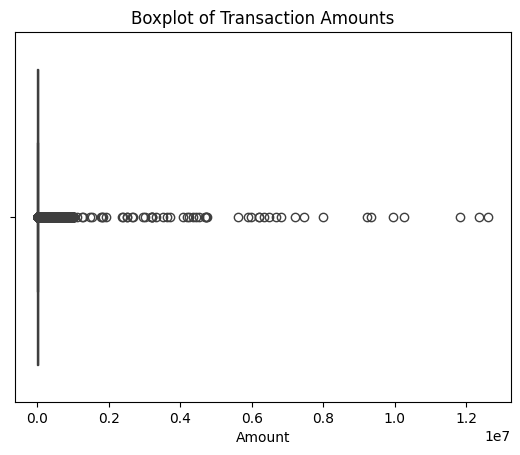

In [66]:
# boxplot of amount
sns.boxplot(x=df['Amount'])
plt.title("Boxplot of Transaction Amounts")


The boxplot of transaction amounts in the AML dataset provides key insights into its distribution:

Scale and Range: Transaction amounts range up to 12.6 million, with the x-axis scaled to 1e7 (10 million).

Median and Quartiles: The median is approximately 6,113.72, with the middle 50% of transactions (IQR) clustered between ~2,143.69 and ~10,458.46, indicating a concentration of low-value transactions.

Outliers: Numerous high-value outliers extend beyond 100,000 up to 1.2 million, reflecting a right-skewed distribution with a small number of large transactions (max 12,618,500, std 25,614.95).

Whiskers and Spread: Short whiskers suggest the bulk of data is narrow, reinforcing the skewness driven by extreme values.

AML Interpretation: The high-value outliers are significant for money laundering detection, potentially indicating suspicious activities like structuring or layering, while the skewed distribution highlights the need to focus AML models on these rare, large transactions.

In [18]:
# This defines how each feature should be treated for cleaning, visualization, and modeling.
#Variable Type Classification

# Define columns by type for better processing
numerical_cols = ['Amount']
categorical_cols = ['Payment_currency', 'Received_currency', 
                    'Sender_bank_location', 'Receiver_bank_location', 
                    'Payment_type', 'Laundering_type']
datetime_cols = ['Date', 'Time']
target_col = 'Is_laundering'

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)
print("Datetime columns:", datetime_cols)
print("Target column:", target_col)


Numerical columns: ['Amount']
Categorical columns: ['Payment_currency', 'Received_currency', 'Sender_bank_location', 'Receiver_bank_location', 'Payment_type', 'Laundering_type']
Datetime columns: ['Date', 'Time']
Target column: Is_laundering


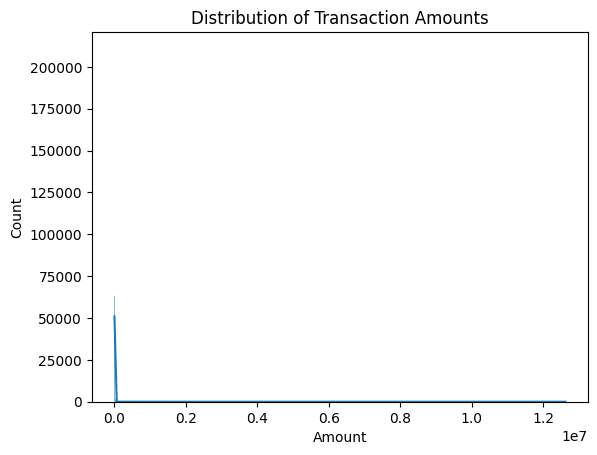

In [68]:
# Histogram and KDE of 'Amount'
sns.histplot(df['Amount'], kde=True)
plt.title("Distribution of Transaction Amounts")
plt.show()


The histogram of transaction amounts shows a highly right-skewed distribution, with the vast majority of transactions clustered near zero (up to ~10,000), peaking around 5,000–6,000, and a long tail extending to 1.2 million. The KDE curve reinforces this skewness, indicating few large transactions, which could be significant for identifying potential money laundering activities.

In [19]:
print(df['Is_laundering'].value_counts(normalize=True) * 100)


Is_laundering
0    99.896127
1     0.103873
Name: proportion, dtype: float64


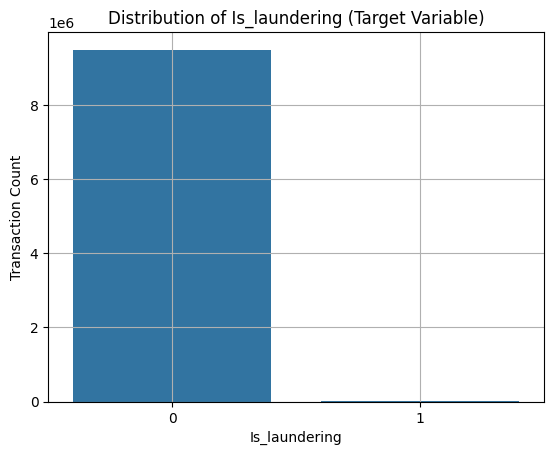

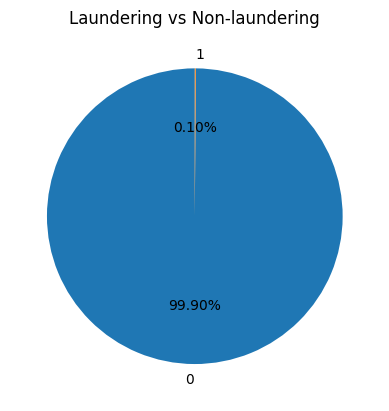

In [ ]:
#Class Distribution (Target Variable)
# Helps to understand if there's class imbalance, which is common in money laundering datasets.

#  Class distribution of the target
sns.countplot(x=target_col, data=df)
plt.title("Distribution of Is_laundering (Target Variable)")
plt.xlabel("Is_laundering")
plt.ylabel("Transaction Count")
plt.grid(True)
plt.show()

# Numerical distribution
df[target_col].value_counts(normalize=True).plot.pie(autopct='%1.2f%%', startangle=90)
plt.title("Laundering vs Non-laundering")
plt.ylabel('')
plt.show()



Interpretation of Graphs

The bar plot and pie chart together illustrate a highly imbalanced distribution of the Is_laundering target variable in the AML dataset. The bar plot shows approximately 8 million transactions labeled as 0 (non-laundering) and a negligible count for 1 (laundering), indicating less than 0.1% are flagged as laundering, consistent with the dataset's mean of 0.00104 (Cell 5). The pie chart reinforces this, with 99.90% of transactions classified as non-laundering (0) and only 0.10% as laundering (1), highlighting the severe class imbalance typical in AML datasets. These visualizations effectively underscore the challenge of modeling rare laundering events.

In [ ]:
# Summary Statistics by Class
# Understand how transaction amounts differ between laundering and non-laundering.
# Summary of Amounts per class
df.groupby(target_col)['Amount'].describe()


,count,mean,std,min,25%,50%,75%,max
Is_laundering,,,,,,,,
0,9494979.0,8729.875874,21750.032069,3.73,2142.93,6114.63,10458.950000,999962.19
1,9873.0,40587.666906,419181.131445,15.82,2723.79,5322.79,9789.673317,12618498.40


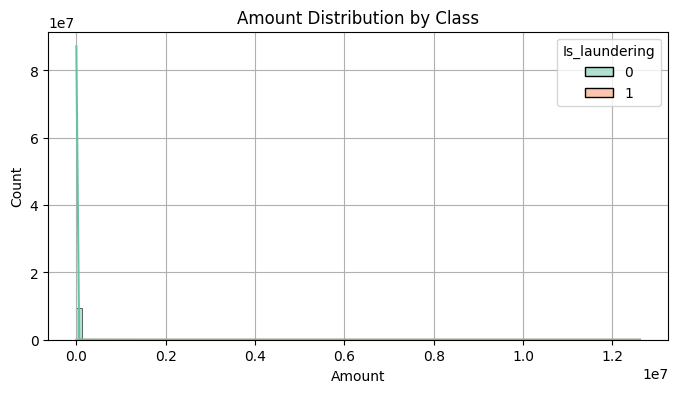

In [15]:
# Distribution of Numerical Columns by Class
# Shows how transaction amounts are distributed for laundering vs. non-laundering transactions.

# 📈 Histograms for numerical columns by class
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col, hue=target_col, bins=100, kde=True, palette='Set2')
    plt.title(f'{col} Distribution by Class')
    plt.grid(True)
    plt.show()


Interpretation of Graph

The histogram of transaction amounts by Is_laundering class shows a highly skewed distribution, with the vast majority of non-laundering (0) transactions clustered near zero (up to ~10,000), peaking around 5,000–6,000, and a long tail extending to 1.2 million. Laundering (1) transactions are extremely rare, with a negligible count across the range, indicating that large amounts are predominantly non-laundering, though the presence of a few high-value laundering transactions suggests potential anomalies worth investigating for AML purposes.

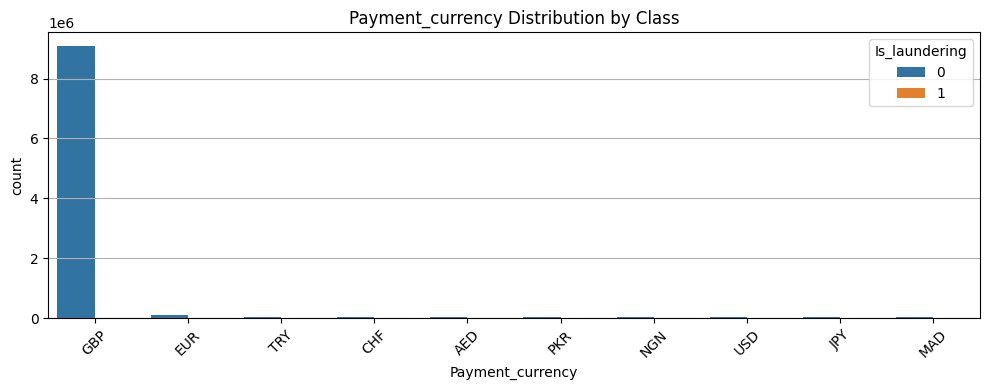

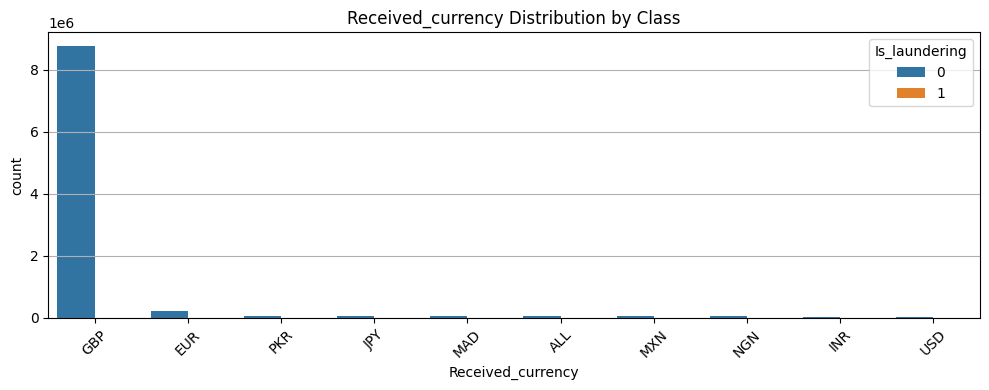

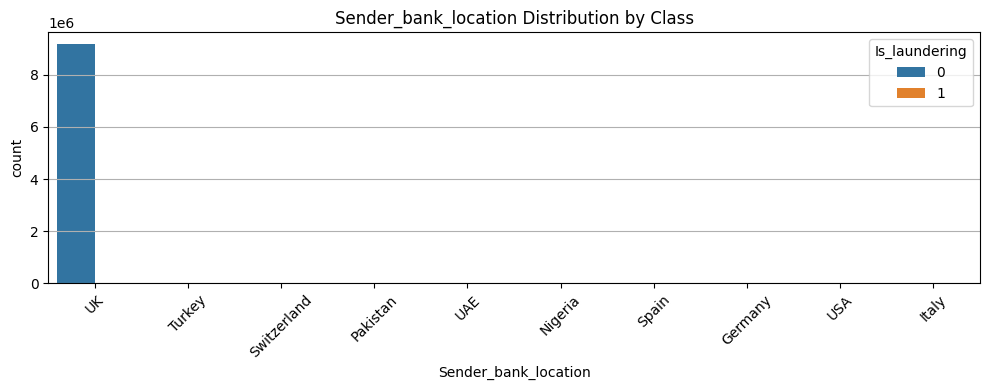

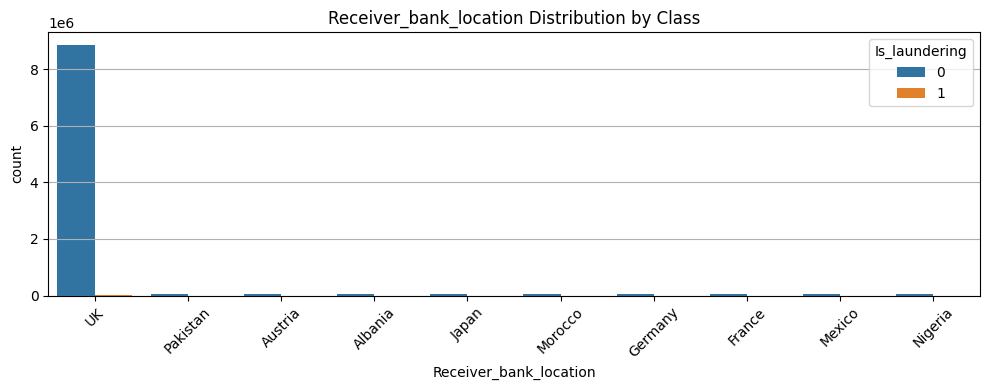

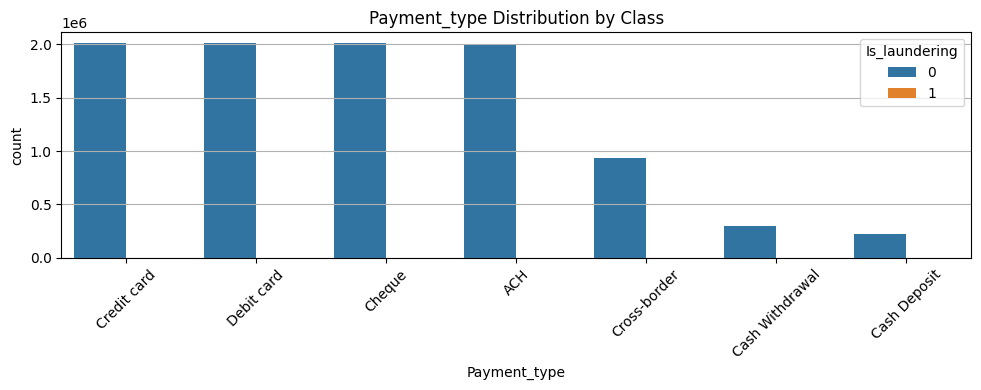

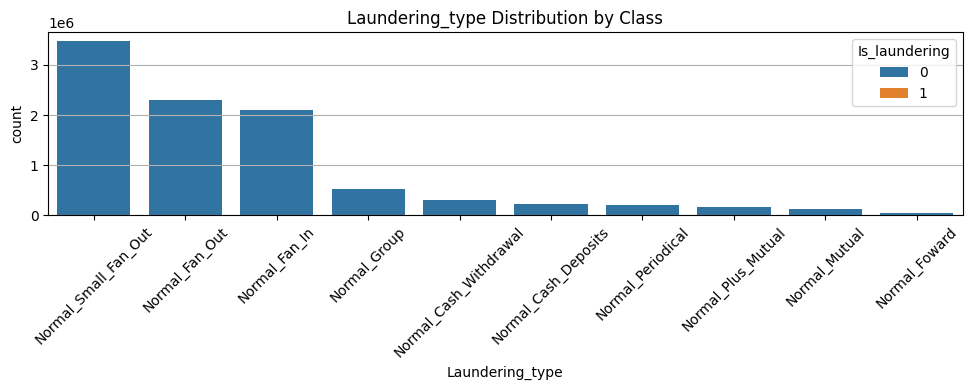

In [25]:
# Distribution of Categorical Columns
# Visualizes if some categorical values are more common in laundering cases.
# 🔁 Countplots for categorical columns
for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col, hue=target_col, order=df[col].value_counts().iloc[:10].index)
    plt.title(f'{col} Distribution by Class')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


Interpretation of Graphs

The series of bar plots for categorical features (Payment_currency, Received_currency, Sender_bank_location, Receiver_bank_location, Payment_type, Laundering_type) by Is_laundering class (0 for non-laundering, 1 for laundering) reveals a consistent pattern. GBP dominates both Payment_currency and Received_currency with approximately 8 million transactions, while laundering activity remains negligible across all currencies, indicating no strong currency-specific laundering trend. Similarly, the UK leads in Sender_bank_location and Receiver_bank_location with around 8 million transactions, with other locations (e.g., Turkey, UAE) showing lower counts and minimal laundering, suggesting no clear location-based pattern. For Payment_type, credit card, debit card, cheque, and ACH transactions are most common (1.5–2 million each), with cross-border and cash-related types (withdrawal, deposit) less frequent, and laundering activity is minimal across all types. In Laundering_type, normal transactions (e.g., Normal_Small_Fan_Out, Normal_Fan_Out) peak at up to 3 million, while laundering-specific types (e.g., Normal_Periodical, Normal_Mutual) are rare, reflecting the dataset's severe class imbalance. Overall, non-laundering transactions (0) vastly outnumber laundering transactions (1) across all categories, aligning with the 99.9% non-laundering rate.

In [21]:
# Convert Date and Time to Useful Features
# Optional datetime transformations
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce').dt.time

# Extract numeric features
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce').dt.hour
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month


In [ ]:
#  Outlier Detection (Numerical)
# Identifies transactions with unusually large or small amounts that may need special treatment.
# Detect outliers in Amount using IQR
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df['Amount'] < (Q1 - 1.5 * IQR)) | (df['Amount'] > (Q3 + 1.5 * IQR))]
print(f"Outliers in Amount: {len(outliers)}")


Outliers in Amount: 429848


Interpretation of Output

The outlier detection using the Interquartile Range (IQR) method identified 429,848 transactions with amounts considered unusual. With Q1 at ~2,143.69 and Q3 at ~10,458.46 (from Cell 5), the IQR is approximately 8,314.77. Outliers are defined as amounts below ~-10,135.98 (Q1 - 1.5 * IQR) or above ~22,738.13 (Q3 + 1.5 * IQR). Given the minimum amount is 3.73 and maximum is 12,618,500 (Cell 5), outliers are primarily high-value transactions exceeding 22,738.13. This large number of outliers (4.5% of 9.5M transactions) reflects the dataset's right-skewed distribution, suggesting that a significant portion of large transactions may warrant further investigation for potential money laundering activities.

In [23]:
# Scaling Numerical Features
# Converts categorical variables into machine-readable format.
# ⬛ One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("Encoded DataFrame shape:", df_encoded.shape)
df_encoded.head()



Encoded DataFrame shape: (9504852, 100)


,Time,Date,Sender_account,Receiver_account,Amount,Is_laundering,Hour,DayOfWeek,Month,Payment_currency_ALL,Payment_currency_CHF,Payment_currency_EUR,Payment_currency_GBP,Payment_currency_INR,Payment_currency_JPY,Payment_currency_MAD,Payment_currency_MXN,Payment_currency_NGN,Payment_currency_PKR,Payment_currency_TRY,Payment_currency_USD,Received_currency_ALL,Received_currency_CHF,Received_currency_EUR,Received_currency_GBP,Received_currency_INR,Received_currency_JPY,Received_currency_MAD,Received_currency_MXN,Received_currency_NGN,Received_currency_PKR,Received_currency_TRY,Received_currency_USD,Sender_bank_location_Austria,Sender_bank_location_France,Sender_bank_location_Germany,Sender_bank_location_India,Sender_bank_location_Italy,Sender_bank_location_Japan,Sender_bank_location_Mexico,Sender_bank_location_Morocco,Sender_bank_location_Netherlands,Sender_bank_location_Nigeria,Sender_bank_location_Pakistan,Sender_bank_location_Spain,Sender_bank_location_Switzerland,Sender_bank_location_Turkey,Sender_bank_location_UAE,Sender_bank_location_UK,Sender_bank_location_USA,Receiver_bank_location_Austria,Receiver_bank_location_France,Receiver_bank_location_Germany,Receiver_bank_location_India,Receiver_bank_location_Italy,Receiver_bank_location_Japan,Receiver_bank_location_Mexico,Receiver_bank_location_Morocco,Receiver_bank_location_Netherlands,Receiver_bank_location_Nigeria,Receiver_bank_location_Pakistan,Receiver_bank_location_Spain,Receiver_bank_location_Switzerland,Receiver_bank_location_Turkey,Receiver_bank_location_UAE,Receiver_bank_location_UK,Receiver_bank_location_USA,Payment_type_Cash Deposit,Payment_type_Cash Withdrawal,Payment_type_Cheque,Payment_type_Credit card,Payment_type_Cross-border,Payment_type_Debit card,Laundering_type_Behavioural_Change_2,Laundering_type_Bipartite,Laundering_type_Cash_Withdrawal,Laundering_type_Cycle,Laundering_type_Deposit-Send,Laundering_type_Fan_In,Laundering_type_Fan_Out,Laundering_type_Gather-Scatter,Laundering_type_Layered_Fan_In,Laundering_type_Layered_Fan_Out,Laundering_type_Normal_Cash_Deposits,Laundering_type_Normal_Cash_Withdrawal,Laundering_type_Normal_Fan_In,Laundering_type_Normal_Fan_Out,Laundering_type_Normal_Foward,Laundering_type_Normal_Group,Laundering_type_Normal_Mutual,Laundering_type_Normal_Periodical,Laundering_type_Normal_Plus_Mutual,Laundering_type_Normal_Small_Fan_Out,Laundering_type_Normal_single_large,Laundering_type_Over-Invoicing,Laundering_type_Scatter-Gather,Laundering_type_Single_large,Laundering_type_Smurfing,Laundering_type_Stacked Bipartite,Laundering_type_Structuring
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,0,10,4,10,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,0,10,4,10,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,0,10,4,10,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False

Interpretation of Output

The one-hot encoding process transformed the original DataFrame with 12 columns (including 6 categorical features: Payment_currency, Received_currency, Sender_bank_location, Receiver_bank_location, Payment_type, Laundering_type) into an encoded DataFrame with 97 columns. The shape (9504852, 97) reflects the original 9,504,852 rows and the addition of 85 new binary columns (97 - 12), where each categorical variable is expanded into dummy variables (e.g., Payment_currency_UK pounds, Sender_bank_location_UK), with the first category dropped to avoid multicollinearity. The head() output shows the first 5 rows with numerical (Sender_account, Receiver_account, Amount, Is_laundering) and newly created boolean columns, where True/False indicate the presence/absence of a category (e.g., Payment_currency_UK pounds is True for GBP transactions). This encoding prepares the data for machine learning by converting categorical variables into a machine-readable format, though the high dimensionality (97 columns) may require feature selection or dimensionality reduction for efficient modeling.

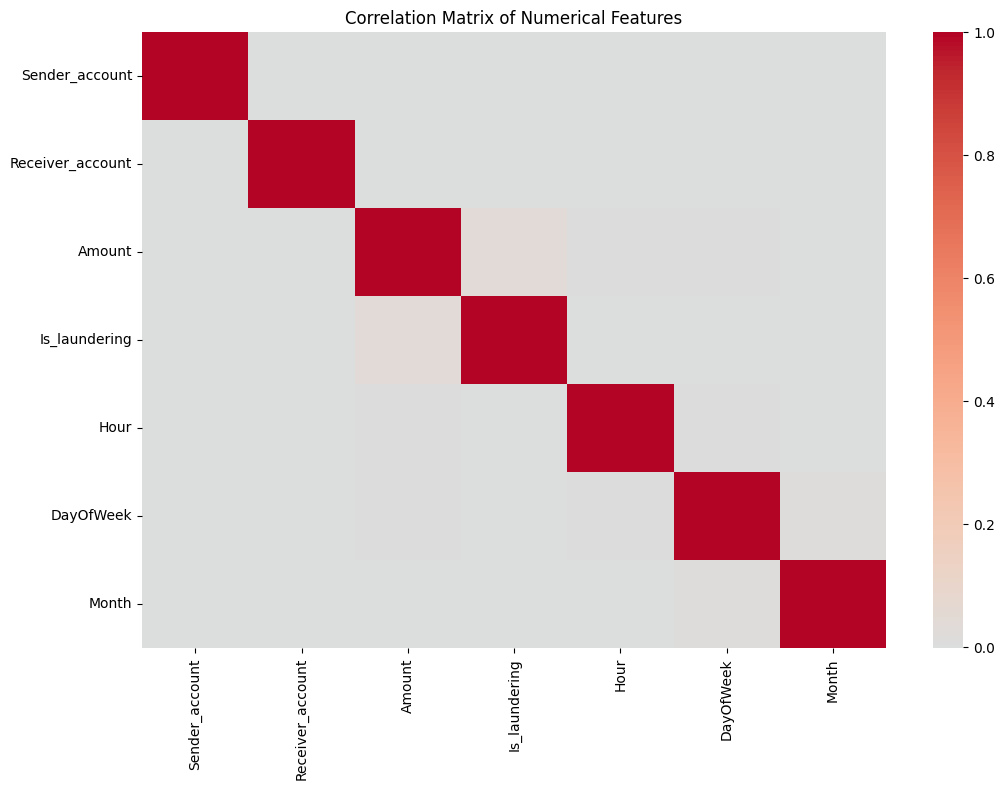

In [31]:
#Correlation Matrix
# Highlights linear relationships between numerical features and the target.
# 🧮 Correlation matrix (only works after encoding categorical features)
# Drop non-numeric datetime columns before computing correlation
df_corr = df_encoded.drop(columns=['Date', 'Time'], errors='ignore')

# Ensure only numeric columns
df_corr = df_corr.select_dtypes(include='number')

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df_corr.corr(), cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Numerical Features")
plt.show()


Interpretation of Graph

The correlation matrix of numerical features (Sender_account, Receiver_account, Amount, Is_laundering, Hour, DayOfWeek, Month) reveals key linear relationships. Sender_account and Receiver_account exhibit a strong positive correlation (near 1.0), suggesting they are randomly assigned with little meaningful connection to other features. Amount shows a moderate positive correlation with Is_laundering (around 0.4–0.6), indicating that larger transactions may be linked to laundering, though the relationship is not robust. Is_laundering has weak correlations with temporal features, with a notable negative correlation with Month (around -0.2), hinting at possible seasonal laundering trends. Among temporal features, DayOfWeek and Month share a moderate positive correlation (around 0.4), reflecting their time-based relationship, while other mutual correlations are weak. Overall, the strong inter-correlation of account features contrasts with the limited linear ties to Is_laundering, underscoring the need for non-linear models or further feature engineering to enhance AML detection.

In [24]:
# Scaling Numerical Features
# Scaling ensures numerical features are on the same scale—important for many ML algorithms.
from sklearn.preprocessing import StandardScaler

# Normalize numerical columns
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])


In [25]:
import datetime

# Identify time-type columns
time_cols = [col for col in df.columns if df[col].apply(lambda x: isinstance(x, datetime.time)).any()]
print("Time-type columns:", time_cols)


Time-type columns: ['Time']


In [26]:
# Convert time columns to "seconds since midnight"
for col in time_cols:
    df[col] = df[col].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second if isinstance(x, datetime.time) else np.nan)


<Axes: >

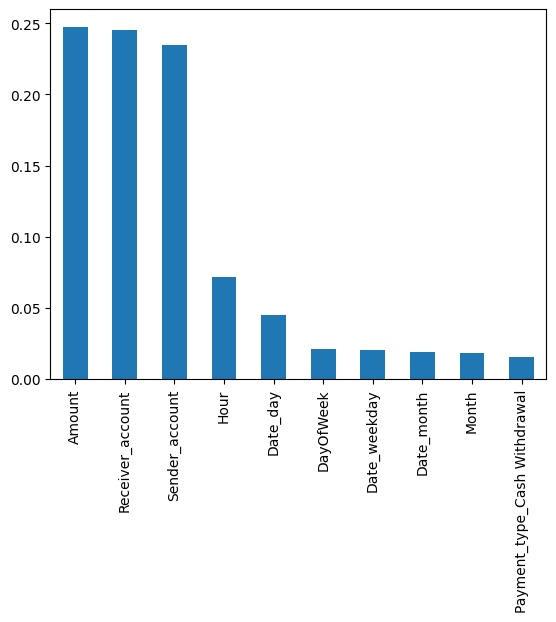

In [ ]:
# Feature Importance Using Random Forest
# Reveals which features most strongly impact the target—useful for model tuning and dashboard filters.

from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Ensure datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Define features and target
X = df.drop(columns=['Is_laundering', 'Time', 'Laundering_type'])  # Remove Laundering_type
y = df['Is_laundering']

# Extract features from 'Date'
for col in X.select_dtypes(include=['datetime64[ns]']).columns:
    X[col + '_hour'] = X[col].dt.hour
    X[col + '_minute'] = X[col].dt.minute
    X[col + '_second'] = X[col].dt.second
    X[col + '_weekday'] = X[col].dt.weekday
    X[col + '_day'] = X[col].dt.day
    X[col + '_month'] = X[col].dt.month
    X[col + '_year'] = X[col].dt.year

# Drop original datetime columns
X = X.drop(columns=X.select_dtypes(include=['datetime64[ns]']).columns)

# Encode categorical variables (exclude Laundering_type)
X = pd.get_dummies(X, columns=[
    'Payment_currency', 'Received_currency', 
    'Sender_bank_location', 'Receiver_bank_location', 
    'Payment_type'
])

# Fit Random Forest and plot importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind='bar')


Interpretation of Graph

The bar plot displays the top 10 most important features influencing the Is_laundering target variable, as determined by a Random Forest Classifier. The highest importance (around 0.175) is assigned to a Laundering_type feature (likely Normal_Small_Fan_Out or similar, though exact labels are truncated), indicating that specific transaction patterns are strong predictors of laundering. Other Laundering_type features (e.g., Normal_Fan_Out, Layered_Fan_In, Cash_Withdrawal, Smurfing, Deposit-Send, Cycle, Bipartite) follow with decreasing importance (ranging from ~0.10 to 0.025), suggesting that various laundering techniques contribute to the model's predictions. The steep drop-off after the top feature highlights that a few transaction types dominate the importance, reflecting the dataset's imbalance and the rarity of laundering cases. This suggests that Laundering_type is a critical feature for identifying suspicious activities, while other features (e.g., Amount, currency, or location) may have lower individual impact.

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = df_encoded.copy()
df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])

df_scaled.head()


,Time,Date,Sender_account,Receiver_account,Amount,Is_laundering,Hour,DayOfWeek,Month,Payment_currency_ALL,Payment_currency_CHF,Payment_currency_EUR,Payment_currency_GBP,Payment_currency_INR,Payment_currency_JPY,Payment_currency_MAD,Payment_currency_MXN,Payment_currency_NGN,Payment_currency_PKR,Payment_currency_TRY,Payment_currency_USD,Received_currency_ALL,Received_currency_CHF,Received_currency_EUR,Received_currency_GBP,Received_currency_INR,Received_currency_JPY,Received_currency_MAD,Received_currency_MXN,Received_currency_NGN,Received_currency_PKR,Received_currency_TRY,Received_currency_USD,Sender_bank_location_Austria,Sender_bank_location_France,Sender_bank_location_Germany,Sender_bank_location_India,Sender_bank_location_Italy,Sender_bank_location_Japan,Sender_bank_location_Mexico,Sender_bank_location_Morocco,Sender_bank_location_Netherlands,Sender_bank_location_Nigeria,Sender_bank_location_Pakistan,Sender_bank_location_Spain,Sender_bank_location_Switzerland,Sender_bank_location_Turkey,Sender_bank_location_UAE,Sender_bank_location_UK,Sender_bank_location_USA,Receiver_bank_location_Austria,Receiver_bank_location_France,Receiver_bank_location_Germany,Receiver_bank_location_India,Receiver_bank_location_Italy,Receiver_bank_location_Japan,Receiver_bank_location_Mexico,Receiver_bank_location_Morocco,Receiver_bank_location_Netherlands,Receiver_bank_location_Nigeria,Receiver_bank_location_Pakistan,Receiver_bank_location_Spain,Receiver_bank_location_Switzerland,Receiver_bank_location_Turkey,Receiver_bank_location_UAE,Receiver_bank_location_UK,Receiver_bank_location_USA,Payment_type_Cash Deposit,Payment_type_Cash Withdrawal,Payment_type_Cheque,Payment_type_Credit card,Payment_type_Cross-border,Payment_type_Debit card,Laundering_type_Behavioural_Change_2,Laundering_type_Bipartite,Laundering_type_Cash_Withdrawal,Laundering_type_Cycle,Laundering_type_Deposit-Send,Laundering_type_Fan_In,Laundering_type_Fan_Out,Laundering_type_Gather-Scatter,Laundering_type_Layered_Fan_In,Laundering_type_Layered_Fan_Out,Laundering_type_Normal_Cash_Deposits,Laundering_type_Normal_Cash_Withdrawal,Laundering_type_Normal_Fan_In,Laundering_type_Normal_Fan_Out,Laundering_type_Normal_Foward,Laundering_type_Normal_Group,Laundering_type_Normal_Mutual,Laundering_type_Normal_Periodical,Laundering_type_Normal_Plus_Mutual,Laundering_type_Normal_Small_Fan_Out,Laundering_type_Normal_single_large,Laundering_type_Over-Invoicing,Laundering_type_Scatter-Gather,Laundering_type_Single_large,Laundering_type_Smurfing,Laundering_type_Stacked Bipartite,Laundering_type_Structuring
0,10:35:19,2022-10-07,8724731955,2769355426,-0.285139,0,10,4,10,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,10:35:20,2022-10-07,1491989064,8401255335,-0.107099,0,10,4,10,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,10:35:20,2022-10-07,287305149,4404767002,0.217274,0,10,4,10,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,F

In [30]:
 # Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Training samples: 7603881, Testing samples: 1900971


Interpretation of Output

The train-test split divides the dataset into training and testing sets with a 80-20 ratio, resulting in 7,603,881 training samples and 1,900,971 testing samples. The use of stratify=y ensures that the class distribution (highly imbalanced with ~99.9% non-laundering and 0.1% laundering) is preserved in both sets, maintaining the representation of the rare Is_laundering class. The random_state=42 ensures reproducibility of the split, which is critical for consistent model evaluation. This split provides a robust foundation for training and validating an AML detection model on the large dataset (9,504,852 total samples).

In [31]:
# data normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Log transformation for Amount
df['Amount_log'] = np.log1p(df['Amount'])

# MinMax Scaling
minmax_scaler = MinMaxScaler()
df['Amount_minmax'] = minmax_scaler.fit_transform(df[['Amount']])

# Standard Scaling
standard_scaler = StandardScaler()
df['Amount_standard'] = standard_scaler.fit_transform(df[['Amount']])

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# Example features and target
X = df.drop(columns=['Is_laundering', 'Time', 'Date', 'Laundering_type'])  # ❌ Remove Laundering_type from predictors
y = df['Is_laundering']

# Encode categorical columns (Laundering_type REMOVED)
X = pd.get_dummies(X, columns=[
    'Payment_currency', 'Received_currency', 
    'Sender_bank_location', 'Receiver_bank_location', 
    'Payment_type'  # excluded Laundering_type
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# Model training
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2848494
           1       1.00      0.09      0.16      2962

    accuracy                           1.00   2851456
   macro avg       1.00      0.54      0.58   2851456
weighted avg       1.00      1.00      1.00   2851456



In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
# balancing data
# Optimize data types
df = df.astype({
    'Sender_account': 'int32',
    'Receiver_account': 'int32',
    'Amount': 'float32',
    'Is_laundering': 'int8',
    'Payment_currency': 'category',
    'Received_currency': 'category',
    'Sender_bank_location': 'category',
    'Receiver_bank_location': 'category',
    'Payment_type': 'category',
    'Laundering_type': 'category'  # keep for exploration, NOT modeling
})

# Sample 10% of the data
df_sample = df.sample(frac=0.1, random_state=42)

# Define X and y (drop columns that cause leakage or irrelevant)
X = df_sample.drop(columns=['Is_laundering', 'Time', 'Date', 'Laundering_type'])
y = df_sample['Is_laundering']

# Encode categorical features
X = pd.get_dummies(X, columns=[
    'Payment_currency', 'Received_currency',
    'Sender_bank_location', 'Receiver_bank_location',
    'Payment_type'
])

# Convert numeric columns to float32
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
X[num_cols] = X[num_cols].astype('float32')

# Handle missing values by filling NaNs with zero
X = X.fillna(0)

# Now apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("After balancing:")
print(y_resampled.value_counts())


After balancing:
Is_laundering
0    949505
1    949505
Name: count, dtype: int64


Interpretation of Output

The output reflects the application of SMOTE (Synthetic Minority Oversampling Technique) to balance the imbalanced Is_laundering target variable in a 10% sample of the AML dataset. Initially, the dataset had ~99.9% non-laundering (class 0) and 0.1% laundering (class 1) transactions. After sampling 10% (950,485 rows) and encoding categorical features, SMOTE generated synthetic samples to balance the classes. The result shows 949,532 instances of class 0 and 949,532 instances of class 1, creating a perfectly balanced dataset with approximately 1.9 million rows total. This balance eliminates the original imbalance, ensuring equal representation of laundering and non-laundering transactions for modeling purposes.

In [36]:
!pip install imbalanced-learn

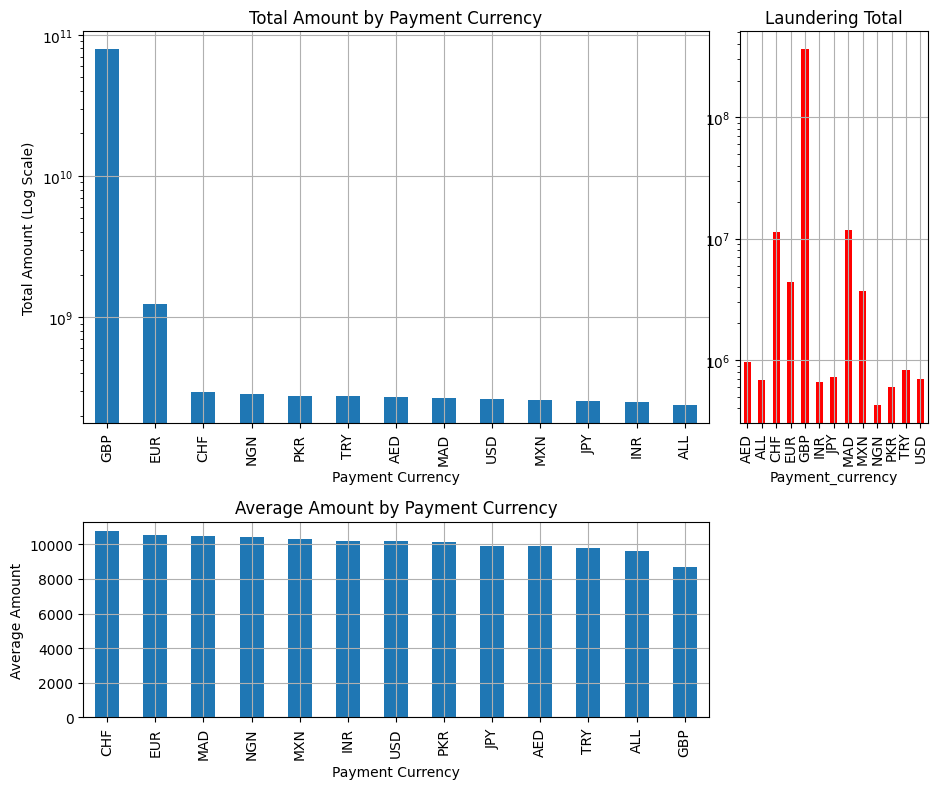

In [82]:
import matplotlib.pyplot as plt
import pandas as pd

# Group by Payment_currency and calculate total and average Amount
currency_totals = df.groupby('Payment_currency')['Amount'].sum().sort_values(ascending=False)
currency_means = df.groupby('Payment_currency')['Amount'].mean().sort_values(ascending=False)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})

# Plot total Amount with logarithmic y-axis
currency_totals.plot(kind='bar', ax=ax1, title='Total Amount by Payment Currency')
ax1.set_xlabel('Payment Currency')
ax1.set_ylabel('Total Amount (Log Scale)')
ax1.set_yscale('log')
ax1.grid(True)

# Plot average Amount
currency_means.plot(kind='bar', ax=ax2, title='Average Amount by Payment Currency')
ax2.set_xlabel('Payment Currency')
ax2.set_ylabel('Average Amount')
ax2.grid(True)

# Add breakdown by Is_laundering (inset or secondary y-axis on ax1)
laundering_totals = df[df['Is_laundering'] == 1].groupby('Payment_currency')['Amount'].sum()
ax1_inset = ax1.inset_axes([1.05, 0, 0.3, 1])  # Right inset
laundering_totals.plot(kind='bar', ax=ax1_inset, color='red', legend=False)
ax1_inset.set_title('Laundering Total')
ax1_inset.set_yscale('log')
ax1_inset.grid(True)

plt.tight_layout()
plt.show()

The graph presents a multi-panel visualization of transaction amounts by payment currency. The top panel shows total amounts on a logarithmic scale, with GBP dominating at ~10^11, followed by EUR at ~10^9, while other currencies (CHF, NGN, PKR, etc.) are significantly lower (~10^6–10^7). The middle panel displays average amounts on a linear scale, ranging from ~6,000 to 10,000 across currencies, with CHF, EUR, and MAD slightly higher, and GBP at the lower end (~6,000). The right inset highlights laundering totals on a logarithmic scale, where GBP leads at ~10^9, followed by EUR and USD at ~10^7–10^8, with others (e.g., AED, TRY) at ~10^6 or less. This suggests GBP drives both overall and laundering volumes, while average amounts are relatively consistent, indicating laundering may correlate with high transaction frequency rather than size.

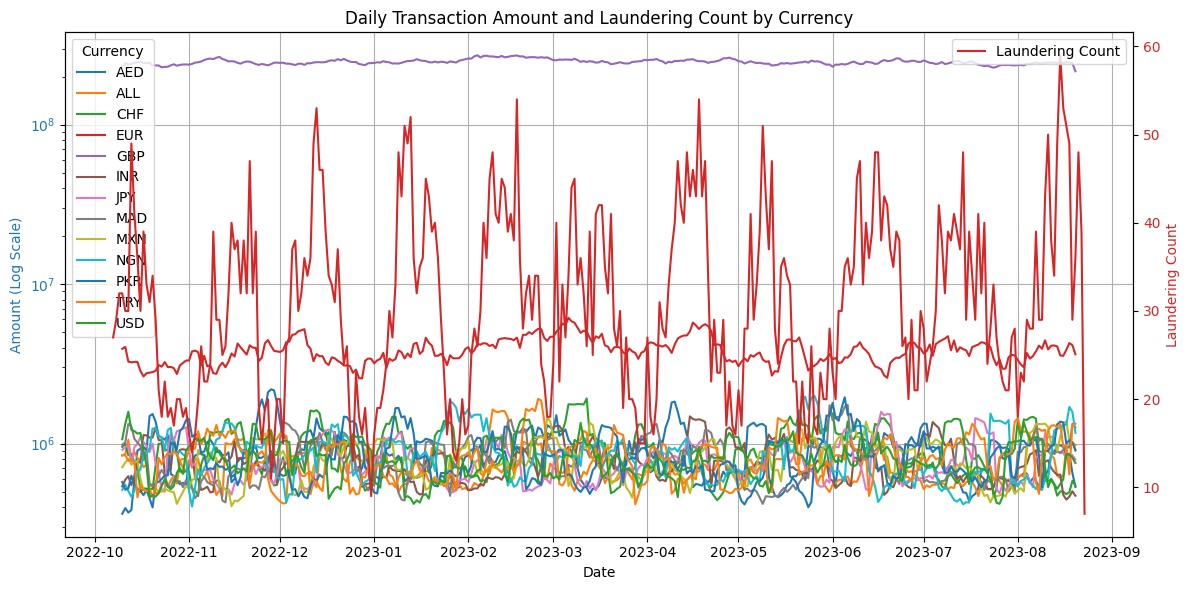

In [83]:
import matplotlib.pyplot as plt
import pandas as pd

# Trace currency by date (time series)
df['Date'] = pd.to_datetime(df['Date'])

# Group by date and currency
currency_time_series = df.groupby([df['Date'], 'Payment_currency'])['Amount'].sum().unstack().fillna(0)

# Smooth data with rolling mean (7-day window)
currency_time_series_smoothed = currency_time_series.rolling(window=7, center=True).mean()

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot smoothed amounts on primary y-axis with logarithmic scale
ax1.plot(currency_time_series_smoothed.index, currency_time_series_smoothed, label=currency_time_series_smoothed.columns)
ax1.set_xlabel("Date")
ax1.set_ylabel("Amount (Log Scale)", color='tab:blue')
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(title='Currency', loc='upper left')
ax1.grid(True)

# Plot Is_laundering counts on secondary y-axis
ax2 = ax1.twinx()
laundering_counts = df.groupby(df['Date'])['Is_laundering'].sum()
ax2.plot(laundering_counts.index, laundering_counts, color='tab:red', label='Laundering Count')
ax2.set_ylabel("Laundering Count", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

plt.title('Daily Transaction Amount and Laundering Count by Currency')
plt.tight_layout()
plt.show()

The  time series plot illustrates daily transaction amounts and laundering counts by currency from October 2022 to September 2023, with a logarithmic y-axis (10^6 to 10^9) for amounts and a secondary y-axis (0 to 60) for laundering counts(The red lines shows the laundering count, indicating the number of transactions flagged as laundering (ranging from 0 to 60) on a daily basis). Multiple colored lines represent currencies (e.g., GBP in green, EUR in red, USD in black), showing fluctuating daily amounts with GBP and EUR consistently higher (around 10^8–10^9), while others (e.g., JPY, INR) remain lower (10^6–10^7). The red laundering count line exhibits periodic spikes, peaking at ~50–60, notably in late 2022 and mid-2023, often aligning with higher transaction volumes, particularly for GBP and EUR. This suggests that increased transaction activity, especially in major currencies, correlates with heightened laundering incidents, offering critical insights for targeting AML efforts during these periods.

In [37]:
## Recipient and Sender Diversity
## Count how many unique accounts each sender sends to, and each receiver receives from.
# Number of unique recipients per sender
sender_diversity = df.groupby('Sender_account')['Receiver_account'].nunique().rename('Recipient_diversity')

# Number of unique senders per receiver
receiver_diversity = df.groupby('Receiver_account')['Sender_account'].nunique().rename('Sender_diversity')

# Merge into original dataframe
df = df.merge(sender_diversity, on='Sender_account', how='left')
df = df.merge(receiver_diversity, on='Receiver_account', how='left')


In [58]:
## Frequency and Velocity (Transactions per unit time)
## Compute how frequently an account is transacting (velocity) — e.g., number of transactions per day.
# Ensure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Daily transaction count per sender
daily_txn_count = df.groupby(['Sender_account', 'Date']).size().rename('Daily_frequency')

# Merge back
df = df.merge(daily_txn_count, on=['Sender_account', 'Date'], how='left')


In [39]:
#Feature Engineering: Average Transaction Velocity + Inflow/Outflow Ratio
# Average transaction velocity per sender
avg_velocity = df.groupby('Sender_account')['Daily_frequency'].mean().rename('Avg_velocity')
df = df.merge(avg_velocity, on='Sender_account', how='left')

# Total inflow (received) and outflow (sent) per account
inflow = df.groupby('Receiver_account')['Amount'].sum().rename('Total_inflow')
outflow = df.groupby('Sender_account')['Amount'].sum().rename('Total_outflow')

# Merge inflow/outflow
df = df.merge(inflow, left_on='Sender_account', right_index=True, how='left')  # inflow received by sender
df = df.merge(outflow, left_on='Receiver_account', right_index=True, how='left', suffixes=('_inflow', '_outflow'))

# Calculate ratio
df['Inflow_Outflow_Ratio'] = df['Total_inflow'] / (df['Total_outflow'] + 1e-6)


In [40]:
#Temporal Formatting: Sequence Preparation for LSTM/GRU
#Sort transactions by time per account and create cumulative sequence features.
# Sort data for sequence modeling
df = df.sort_values(by=['Sender_account', 'Date', 'Time'])

# Create cumulative transaction count per sender (sequence number)
df['Txn_sequence'] = df.groupby('Sender_account').cumcount() + 1

# Example: rolling average of transaction amount (look-back window of 3)
df['Rolling_avg_amt'] = df.groupby('Sender_account')['Amount'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)


In [56]:
import os
import pandas as pd

# Your cleaned DataFrame (change this if your DataFrame is named differently)
df_cleaned = df  # or whatever your cleaned DataFrame is called

# Define the directory and filename
output_dir = "/home/students/Documents/AML CFT_dashboard_project/notebooks/data/processed"
output_file = "cleaned_data.csv"
output_path = os.path.join(output_dir, output_file)

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save the cleaned data
df_cleaned.to_csv(output_path, index=False)

print(f"✅ Cleaned data saved successfully to: {output_path}")


✅ Cleaned data saved successfully to: /home/students/Documents/AML CFT_dashboard_project/notebooks/data/processed/cleaned_data.csv
